In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [151]:
from collections import Counter

from utils import *
from word_network import WordNetwork

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy


from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [3]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [4]:
datasize = 100
max_document_length = None

index = -1
train_docs, labels = [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if (not status) or (max_document_length is not None and len(doc) > max_document_length):
            continue
        
        labels.append(categories[size_index])
        train_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)

In [5]:
index = 0
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index]}")

Topic: alt.atheism
i think that domestication will change behavior to a large degree domesticate animal exhibit behavior not found in the wild i don t think that they can be view a good representative of the wild animal kingdom since they have be breed for thousand of year to produce certain behavior etc


In [6]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[100, 100, 100, 100]


In [7]:
print(f"there are {len(train_docs)} docs")

there are 400 docs


### Initialize Vectorizer

In [8]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(train_docs)

vocabulary = vectorizer.get_feature_names()
print("word_count is", len(vocabulary))

word_count is 9116


### Prepare Datatset

In [9]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()

total_num_of_documents = len(train_doc_vectors)
print(f"{total_num_of_documents} train_docs")

400 train_docs


### Word-Word Ratio

In [50]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_doc_frequency = (word_freq_in_doc > 0).astype(int)
probability = word_doc_frequency.sum(0) / len(train_doc_vectors)

for word in tqdm(vocabulary):
    pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0) / total_num_of_documents
#     word_word_co[word] = pxy / (probability[word] * probability)
#     word_word_co[word][word_word_co[word] > 0] = word_word_co[word][word_word_co[word] > 0]**-1
    word_word_co[word] = np.nan_to_num(sigmoid(np.nan_to_num(np.log2(pxy / (probability[word] * probability)))))

# word_word_co = (word_word_co.T / word_word_co.sum(1)).T
print(f"word_word_co has shape {word_word_co.shape}")

c:\program files\python37\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\christian\Documents\christian\work\python\cyberspace\semantic_segmentation\utils.py:15: RuntimeWarning: overflow encountered in power
  return 1 / (1 + (np.e**-x))



word_word_co has shape (9116, 9116)


In [56]:
word_word_co.head()

,000,000th,0029,007,01,011,0119,013,02,0245,...,zillion,zimogliad,ziona,zionism,zionist,zman,zone,zoo,zulu,zur
000,0.990471,0.000000,0.000000,0.990471,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.990471,0.0,0.0,0.886843,0.990471,0.0,0.0,0.0,0.0
000th,0.000000,0.999824,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
0029,0.000000,0.000000,0.999824,0.000000,0.999141,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
007,0.990471,0.000000,0.000000,0.999824,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.999824,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
01,0.000000,0.000000,0.999141,0.000000,0.999141,0.0,0.0,0.0,0.0,0.999141,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


### Calculate Word Trust ratio

In [57]:
word_entropy = pd.DataFrame(data=np.nan_to_num(calculate_entropy(word_word_co.T, base=2)), columns=[0], index=vocabulary)[0]
word_trust_factor = pd.DataFrame(data=gaussian(abs(word_entropy - word_entropy.mean())), columns=[0], index=vocabulary)[0]
word_trust_factor = word_trust_factor / word_trust_factor.max()

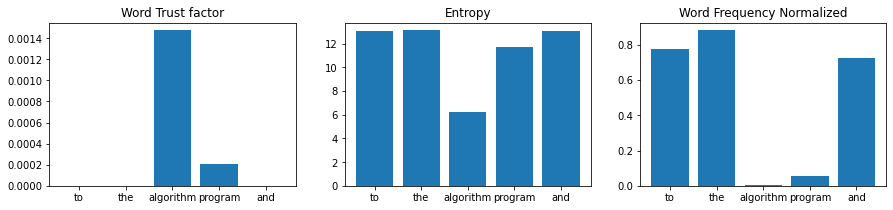

In [58]:
words = ["to", "the", "algorithm", "program", "and"]
# words = np.array(vocabulary)[np.random.randint(len(vocabulary), size=5)]

fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title(f"Word Trust factor")
ax1.bar(words, word_trust_factor[words])

ax2.set_title(f"Entropy")
ax2.bar(words, word_entropy[words])

ax3.set_title(f"Word Frequency Normalized")
ax3.bar(words, probability[words])

plt.show()

### Observe word_word_co ratios

In [62]:
wwc = (word_word_co * word_trust_factor)

=== Ploting software against ['to', 'the', 'algorithm', 'program', 'and'] ===


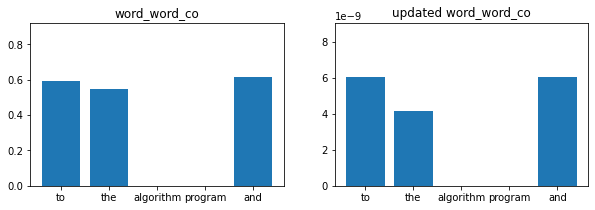

In [63]:
word = "software"

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

print(f"=== Ploting {word} against {words} ===")

values = word_word_co.loc[word][words]
ax1.set_title(f"word_word_co")
ax1.set_ylim(0, 1.5*values.max())
ax1.bar(words, values)

values = wwc.loc[word][words]
ax2.set_title(f"updated word_word_co")
ax2.set_ylim(0, 1.5*values.max())
ax2.bar(words, values)

plt.show()

In [64]:
wwc.loc["war"].sort_values(ascending=False).head(10)

racial         0.986139
ii             0.977528
prior          0.974123
possession     0.974123
supporter      0.972492
fighter        0.969330
ownership      0.968076
espionage      0.966075
revisionist    0.962909
sdpa           0.962873
Name: war, dtype: float64

In [65]:
word_word_co.loc["war"].sort_values(ascending=False).head(10)

zur                  0.985958
interestingly        0.985958
inhumane             0.985958
ingredient           0.985958
chancy               0.985958
sergey               0.985958
turbocharger         0.985958
ineffective          0.985958
indoors              0.985958
indistinguishable    0.985958
Name: war, dtype: float64

In [18]:
word_word_co = wwc

### Update word_word_co with word_word_co

In [66]:
doc_word_distr = word_doc_frequency * word_trust_factor
# doc_word_distr = (doc_word_distr.T / doc_word_distr.sum(1)).T.fillna(0)

In [67]:
doc_index = 13
word_doc_frequency.iloc[doc_index].sort_values(ascending=False).head(10)

directly     1
of           1
didn         1
10           1
maybe        1
his          1
missile      1
get          1
kill         1
operation    1
Name: 13, dtype: int32

In [68]:
doc_word_distr.iloc[doc_index].sort_values(ascending=False).head(10)

surgical     0.471433
directly     0.124246
missile      0.033719
operation    0.004006
body         0.001636
hit          0.001438
destroy      0.001005
someone      0.000783
house        0.000757
course       0.000725
Name: 13, dtype: float64

In [69]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: talk.politics.mideast
maybe the missile didn t hit directly such that his body get desintegrated of course destroy 10 house to kill someone be not a surgical operation or be it


In [70]:
doc_word_distr.head()

,000,000th,0029,007,01,011,0119,013,02,0245,...,zillion,zimogliad,ziona,zionism,zionist,zman,zone,zoo,zulu,zur
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
for di in range(len(doc_word_distr.index)):
    print(doc_word_distr.iloc[di].sort_values(ascending=False).head(5).index.to_list())
    break

['wild', 'exhibit', 'kingdom', 'animal', 'produce']


In [73]:
(doc_word_distr.mean(0) * word_trust_factor).sort_values(ascending=False).head(10)

punishment    0.019759
perfect       0.016580
definition    0.015489
wrench        0.015072
wild          0.014989
chrysler      0.014963
luck          0.014828
bolt          0.014613
adam          0.014405
launcher      0.014206
dtype: float64

### Define Latent partitions

In [141]:
# reduction = None
# reduction = "pca"
reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 2
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components)
    param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    column_values = [doc_word_distr.mean(1), doc_word_distr.std(1)]
    param_values = np.array(column_values).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

distr_params has shape (400, 2)


In [142]:
distr_params.head()

,mean,std
0,0.000246,0.014820
1,0.000549,0.020743
2,0.000115,0.005121
3,0.002700,0.040580
4,0.000534,0.017456


### Using Kmeans MiniBatch

In [135]:
num_of_topics = 4

In [143]:
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params)

In [144]:
# kmeans_model = MiniBatchKMeans(n_clusters=num_of_topics, random_state=0)

# num_of_iterations = 256

# num_of_samples = len(distr_params)
# batch_size = num_of_samples // 2

# for i in tqdm(range(num_of_iterations)):
#     indices = np.random.randint(num_of_samples, size=batch_size)
    
#     kmeans_model.partial_fit(distr_params.iloc[indices])

# kmeans_model.cluster_centers_.shape

(4, 2)

In [145]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)
wtf = gaussian(normalize(dist, norm="l1", axis=1))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

dist has shape (400, 4), predicted_labels has shape (400,)


In [146]:
# wtf

In [147]:
Counter(predicted_labels)

Counter({1: 184, 3: 108, 2: 82, 0: 26})

In [148]:
voc_array = np.array(vocabulary)

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(doc_word_distr.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].sum(0) * word_trust_factor).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])
    get_topwords(topic)
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    count = Counter()
    for index in indices:
        count[labels[index]] += wtf[index, topic]
        
    print(Counter(labels[indices]))
    get_topwords(topic)

In [149]:
get_top(0)

Counter({'talk.politics.mideast': 13, 'sci.space': 6, 'rec.autos': 4, 'alt.atheism': 3})
weigh          0.071778
sunlight       0.070340
uniform        0.069281
patrol         0.068649
kemal          0.067361
proceeds       0.067130
experienced    0.066641
thru           0.066603
ring           0.066450
improvement    0.066349
dtype: float64


In [150]:
get_top(1)

Counter({'sci.space': 60, 'rec.autos': 51, 'alt.atheism': 39, 'talk.politics.mideast': 34})
prize         0.029226
wrench        0.028265
chrysler      0.027112
punishment    0.026955
wild          0.021710
ibm           0.021515
adam          0.021242
pollution     0.021108
definition    0.020435
leaf          0.019217
dtype: float64


In [131]:
get_top(2)

Counter({'sci.space': 1})
phase            0.903751
constellation    0.850012
measurement      0.758464
built            0.171607
stellar          0.133412
vlbi             0.133412
oscar            0.133412
custom           0.120578
gps              0.069810
navigation       0.037680
dtype: float64


In [132]:
get_top(3)

Counter({'rec.autos': 75, 'sci.space': 68, 'alt.atheism': 59, 'talk.politics.mideast': 44})
chrysler      0.019430
wild          0.015572
ibm           0.015349
perfect       0.015233
wrench        0.013504
definitely    0.013410
prize         0.013068
sun           0.011754
jupiter       0.011618
resistance    0.011605
dtype: float64


### Evaluate Topic model with Train set

In [39]:
score = 0
misclassified_train = []
print("Evaluating Topic Model...")

for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if doc_topic != label_classes[train_labels[doc_index]]:
        misclassified_train.append(doc_index)
    
train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%, {len(misclassified_train)} misclassified\n")

Evaluating Topic Model...


NameError: name 'train_labels' is not defined

### Evaluating Topic Model with test set

In [ ]:
score = 0
print("Evaluating Topic Model...")

misclassified_test = []
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclassified_test.append(doc_index)
    

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%, {len(misclassified_test)} misclassified\n")

### Investigating Misclassification

In [ ]:
training = True
tlabels = train_labels if training else test_labels
tdoc_vectors = train_doc_vectors if training else test_doc_vectors
misclassified = misclassified_train if training else misclassified_test

for doc_index in tqdm(misclassified):
    doc_vector = tdoc_vectors[doc_index]
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    
    xv = doc_topic_word_distr.iloc[np.where(doc_topic_word_distr.sum(1) > 0)]
    print(xv.loc[xv.sum(1).sort_values(ascending=False).index])
    print(train_docs[doc_index])
    print(f"==> predicted_topic = {doc_topic}, actual_topic = {label_classes[tlabels[doc_index]]} \n")
#     break

### Using Latent Dirichlet Allocation

In [ ]:
clf = MultinomialNB(alpha=.01)
clf.fit(train_doc_vectors, train_labels)

train_accuracy = clf.score(train_doc_vectors, train_labels)
test_accuracy = clf.score(test_doc_vectors, test_labels)

print(f"training_accuarcy = {train_accuracy*100:.2f}%, test_accuarcy = {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%")

### Next steps
use softwmax on word_trust factor, apply it on word_doc_norm like in word_word_co to suppress the stop words and make the actual important words more pronounced. use this pronounced words to estimate the related topic in doc